In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Preprocesado y modelado
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import norm
from sklearn.feature_selection import SelectKBest

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns



# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import   RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostClassifier
from xgboost import XGBRegressor 

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


c:\Users\laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# Importación de datos:

file_path = '../data/raw/tudato.csv'  

data = pd.read_csv(file_path)

In [3]:
df = data.copy()

In [4]:
df.loc[df['GHI'] < 0, 'GHI'] = 0
# cambio por 0 los valores negativos, ya que la irradiancia no tiene sentido que sea negativa

### SEPARACIÓN DE DATOS

In [5]:
TRAIN, TEST = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X, y = TRAIN.drop(columns='Precios'), TRAIN['Precios']

In [7]:
print(X.shape, y.shape)


(53701, 9) (53701,)


### FEATURE SELECTION


In [8]:
columnas_log = ['GHI', 'Gas', 'PotenciaViento']


**Distribución features**

In [9]:
columnas_log = ['GHI', 'Gas', 'PotenciaViento']

# Test para comprobar la distribución de las variables:

for i in columnas_log:
# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
    print(i, "Saphiro:", shapiro(X[i]).pvalue)

# Para comprobar la asimetría de una variable podemos calcular su valor skew:
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
    print(i,"Asimetria:", skew(X[i]))


GHI Saphiro: 0.0
GHI Asimetria: 3.7995493100101476
Gas Saphiro: 0.0
Gas Asimetria: 2.378021293897461
PotenciaViento Saphiro: 0.0
PotenciaViento Asimetria: 1.640534430641592


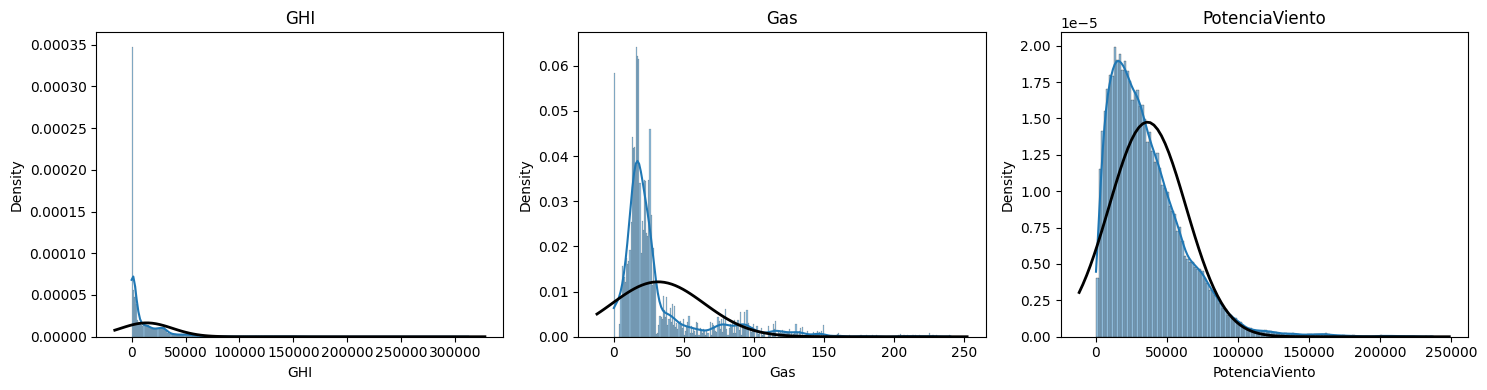

In [10]:
plt.figure(figsize=(15, 4))


for i, column in enumerate(columnas_log, 1):
    plt.subplot(1, 3, i)
    sns.histplot(X[column], kde=True, stat="density")

    mu, std = X[column].mean(), X[column].std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(column)

plt.tight_layout()
plt.show()

**Transformaciones**

In [11]:
pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('log', FunctionTransformer(np.log1p, validate=True), columnas_log)  # Aplica logaritmo
        ],
        remainder='passthrough'  # Mantén las columnas no especificadas
    ),
    StandardScaler()  # Estandarizar todo el DataFrame
)

# Aplica el pipeline al DataFrame
df_log_estandarizado = pipeline.fit_transform(X)


In [12]:
df_log_estandarizado

array([[ 1.38102116,  0.32731215,  2.08576799, ...,  0.37422132,
         0.21377609,  0.82761628],
       [-0.54919993, -0.21275175, -0.67846181, ..., -1.44669242,
        -0.50929999,  0.82761628],
       [ 1.3710639 , -0.0941893 , -2.14914258, ...,  0.94325687,
         0.50300652, -1.20828943],
       ...,
       [-1.62782722,  1.63309458,  0.20697422, ..., -1.21907821,
         1.65992823,  0.82761628],
       [-0.80294808, -0.24451271, -0.01176133, ..., -1.21907821,
         1.22608259, -1.20828943],
       [-1.07006433, -0.02678938,  0.30173989, ...,  0.48802843,
        -1.08776085,  0.82761628]])

In [13]:
df_log_sdt = pd.DataFrame(df_log_estandarizado, columns = X.columns)
df_log_sdt.to_csv('../data/df_log_sdt.csv', sep=',')

df_log_sdt

,GHI,Festivo,Gas,PotenciaViento,Ano,Mes,Dia,Hora,GMT
0,1.381021,0.327312,2.085768,-0.442553,1.201122,1.071088,0.374221,0.213776,0.827616
1,-0.549200,-0.212752,-0.678462,-0.442553,-1.505081,1.071088,-1.446692,-0.509300,0.827616
2,1.371064,-0.094189,-2.149143,-0.442553,0.750088,-0.979795,0.943257,0.503007,-1.208289
3,-1.349031,0.118930,-2.590410,-0.442553,1.652156,-0.686812,-0.991464,-0.653915,0.827616
4,0.291861,-0.247504,0.441495,-0.442553,-1.505081,-0.979795,0.032800,1.081467,-1.208289
...,...,...,...,...,...,...,...,...,...
53696,0.624034,-0.999588,0.909111,2.259614,0.299054,-0.979795,1.512292,1.081467,0.827616
53697,-0.067178,-0.202953,0.183461,2.259614,-1.505081,0.778104,0.260414,-1.376991,0.827616
53698,-1.627827,1.633095,0.206974,-0.442553,1.201122,-0.686812,-1.219078,1.659928,0.827616
53699,-0.802948,-0.244513,-0.011761,-0.442553,-1.505081,-1.272779,-1.219078,1.226083,-1.208289


In [17]:
df_log_sdt.describe()

,GHI,Festivo,Gas,PotenciaViento,Ano,Mes,Dia,Hora,GMT
count,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04,5.370100e+04
mean,-2.143497e-17,1.587775e-16,1.018161e-16,1.825942e-17,-7.626615e-15,5.689529e-17,4.650859e-17,-1.791540e-16,-6.523111e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-3.474154e+00,-3.165228e+00,-5.500540e+00,-4.425535e-01,-1.505081e+00,-1.565762e+00,-1.674307e+00,-1.666222e+00,-1.208289e+00
25%,-8.814497e-01,-3.507798e-01,-5.733907e-01,-4.425535e-01,-1.054047e+00,-9.797955e-01,-8.776569e-01,-7.985304e-01,-1.208289e+00
50%,1.614426e-01,-3.943076e-02,1.471866e-01,-4.425535e-01,-1.519796e-01,-1.008455e-01,3.280000e-02,6.916087e-02,8.276163e-01
75%,8.732960e-01,3.442854e-01,7.180081e-01,-4.425535e-01,7.500882e-01,7.781045e-01,8.294498e-01,9.368522e-01,8.276163e-01
max,2.101025e+00,2.466869e+00,2.542294e+00,2.259614e+00,1.652156e+00,1.657054e+00,1.739907e+00,1.659928e+00,8.276163e-01


### División en train y validation

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_log_sdt, y, test_size=0.2, random_state=42)

In [19]:
X_train.isna().sum()

GHI               0
Festivo           0
Gas               0
PotenciaViento    0
Ano               0
Mes               0
Dia               0
Hora              0
GMT               0
dtype: int64

### Cross validation y elección de modelos

**Modelo 1, sin feature selection**


In [130]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Elastic Net": ElasticNet(),
    "SVR": SVR(),
    "kNN": KNeighborsRegressor(),
    'DTree': DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XgB": XGBRegressor()

}
resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

In [128]:
pd.DataFrame(resultados).T

,0
LinearRegression,-30.679799
Ridge,-30.679765
Lasso,-30.664605
Elastic Net,-31.638343
SVR,-21.463005
kNN,-14.385656
DTree,-19.497139
RandomForest,-15.233824
XgB,-17.570052


### SELECCIONANDO COLUMNAS

In [20]:
names = X.columns

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, y)
print(X_new.shape)
print(sel.scores_)

feature_importance = pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)
feature_importance

(53701, 9)
(53701, 5)
[ 2.60816142  1.26402347 11.5149828   2.12173324  5.14495808  1.66232539
  1.2716096   1.23919152  1.61265497]


,column,score
2,Gas,11.514983
4,Ano,5.144958
0,GHI,2.608161
3,PotenciaViento,2.121733
5,Mes,1.662325
8,GMT,1.612655
6,Dia,1.271610
1,Festivo,1.264023
7,Hora,1.239192


### UTULIZAR STACKING VOTING ETC Y PROBAR ###

In [116]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Elastic Net": ElasticNet(),
    "SVR": SVR(),
    "kNN": KNeighborsRegressor(),
    'DTree': DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XgB": XGBRegressor(),
}
resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X_train.drop(columns=['Dia', 'Festivo', 'Hora']), y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

pd.DataFrame(resultados).T

,0
LinearRegression,-33.686201
Ridge,-33.685937
Lasso,-33.372182
Elastic Net,-32.736447
SVR,-25.791111
kNN,-10.284859
DTree,-11.663279
RandomForest,-9.370354
XgB,-10.417013


**PCA 1**

In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X4D = pca.fit_transform(X_train)

In [118]:
X_train4D = pd.DataFrame(X4D)

In [119]:
modelos = {
      "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Elastic Net": ElasticNet(),
    "SVR": SVR(),
    "kNN": KNeighborsRegressor(),
    'DTree': DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XgB": XGBRegressor(),
}
resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X_train4D, y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

print(pd.DataFrame(resultados)).T

                          0
LinearRegression -30.679799
Ridge            -30.679765
Lasso            -30.664605
Elastic Net      -31.638343
SVR              -21.463005
kNN              -14.385656
DTree            -19.497139
RandomForest     -15.233824
XgB              -17.570052


**PCA 2**

In [22]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
X95 = pca.fit_transform(X_train)

In [24]:
modelos = {
      "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Elastic Net": ElasticNet(),
    "SVR": SVR(),
    "kNN": KNeighborsRegressor(),
    'DTree': DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "XgB": XGBRegressor(),
}
resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X95, y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

print(pd.DataFrame(resultados).T)

                          0
LinearRegression -30.033401
Ridge            -30.033211
Lasso            -29.464965
Elastic Net      -29.873269
SVR              -15.198151
kNN               -7.882101
DTree            -10.682189
RandomForest      -7.959303
XgB               -9.886801


### Optimización de parametros

In [25]:
svr= SVR()
random_f =  RandomForestRegressor()
xgboost =  XGBRegressor()


grid_random_forest = {"n_estimators": [120],
                     "max_depth": [5,10,15,17],
                     "max_features": ["sqrt", 3, 4]                          
                     }


svr_param = {                    
                'C': [0.1],
                'epsilon': [0.1],
                'kernel': ["linear", "poly", "rbf"],
                'gamma': ('scale', 'auto')
            }

xgb_param = {
       'n_estimators': [50, 100, 200],
       'learning_rate': [0.01, 0.05, 0.1],
       'max_depth': [3, 5, 7],
       'subsample': [0.6, 0.8, 1.0],
       'colsample_bytree': [0.6, 0.8, 1.0]
   }

In [26]:
xgb_gs = GridSearchCV(random_f, grid_random_forest, cv=5, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1)
xgb_gs.fit(X95, y_train)

best_model_xgb = xgb_gs.best_estimator_
best_parameters_xgb = xgb_gs.best_params_

print(best_model_xgb)
print('---'*200)
print(best_parameters_xgb)
print('---'*200)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'max_depth': 17, 'max_features': 4, 'n_estimators': 120}
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
random_f_gs = GridSearchCV(xgboost, xgb_param, cv=5, scoring="neg_mean_absolute_error", verbose=1)
random_f_gs.fit(X95, y_train)

best_model_rf = random_f_gs.best_estimator_
best_parameters_rf = random_f_gs.best_params_

print(best_model_rf)
print('---'*200)
print(best_parameters_rf)
print('---'*200)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
svr_gs = GridSearchCV(svr, svr_param, cv=5, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1)
svr_gs.fit(X95, y_train)

best_model_svr = svr_gs.best_estimator_
best_parameters_svr = svr_gs.best_params_

print(best_model_svr)
print('---'*200)
print(best_parameters_svr)
print('---'*200)




Fitting 5 folds for each of 6 candidates, totalling 30 fits


SVR(C=0.1, gamma='auto')
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# models = [('rand_forest', random_f, grid_random_forest),
#          ('svm', svr, svr_param),
#         #  ('xgboost', xgboost, xgb_param)
#         ]

# # Declaro en un diccionario los pipelines e hiperparametros
# models_gridsearch = {}

# for i in models:
#     models_gridsearch[i[0]] = GridSearchCV(i[1],
#                                           i[2],
#                                           cv=5,
#                                           scoring="neg_mean_absolute_error",
#                                           verbose=1,
#                                           n_jobs=-1
#                                           )
#     models_gridsearch[i[0]].fit(X_train, y_train)
    

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

In [131]:
# best_grids = []

# best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]

# best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
# best_grids

### ENTRENAMIENTO Y PREDICCIONES

In [21]:
modelos = {"RandomForest": RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120),
    "XgB": XGBRegressor(colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample= 0.8),
    'SVR': SVR(C=0.1, epsilon=0.1, gamma='auto', kernel='rbf')}

resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

print(pd.DataFrame(resultados).T)

                      0
RandomForest  -5.126702
XgB           -5.485718
SVR          -21.529577


In [29]:
modelos = {"RandomForest": RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120),
    "XgB": XGBRegressor(colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample= 0.8),
    'SVR': SVR(C=0.1, epsilon=0.1, gamma='auto', kernel='rbf')}

resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X95, y_train, cv=5, scoring="neg_mean_absolute_error").mean()]

print(pd.DataFrame(resultados).T)

                      0
RandomForest  -9.043311
XgB           -8.952802
SVR          -21.529577


**MODELO SELECCIONADO**

In [31]:
X_val_95 = pca.transform(X_val)

In [32]:
# Instanciar y entrenar el modelo
modelo = RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120)
modelo.fit(X95, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_val_95)

# y_pred contiene las predicciones de clase para el conjunto de prueba

In [33]:
pd.DataFrame(y_pred, y_val)

,0
Precios,
32.87,36.456309
16.83,42.187405
56.85,54.383163
45.00,51.723376
169.47,174.809068
...,...
42.71,54.620982
72.45,68.451214
71.35,51.351711


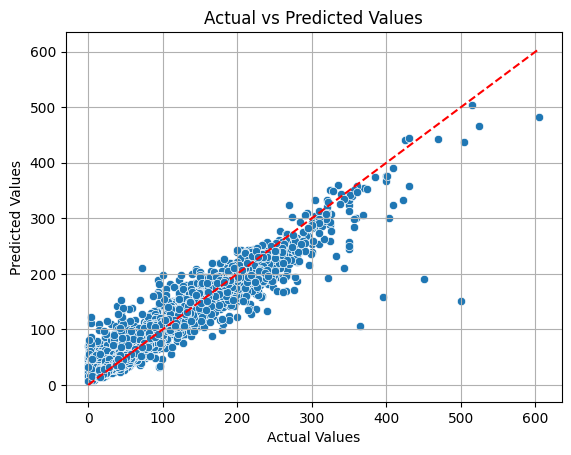

In [46]:
# Assuming y_pred and y_val are pandas Series or arrays
# Create a DataFrame with the predicted and actual values
df = pd.DataFrame({'Predicted': y_pred, 'Actual': y_val})

# Create a scatter plot using Seaborn
sns.scatterplot(data=df, x='Actual', y='Predicted')

# Optionally, add a line of equality (y = x)
sns.lineplot(x=df['Actual'], y=df['Actual'], color='red', linestyle='--')

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
# Show the plot
plt.show()

**Entrenamiento del modelo con todo TRAIN transformado:**


In [47]:
X_TRAIN = pca.fit_transform(df_log_sdt)


modelo = RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120)
modelo.fit(X_TRAIN, y)



RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120)

### PREDICCIONES CON TEST INICIAL


In [49]:
new_data = TEST.drop(columns='Precios')
new_target = TEST['Precios']

In [50]:
# Pipeline para transformar 
pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('log', FunctionTransformer(np.log1p, validate=True), columnas_log)  # Aplica logaritmo
        ],
        remainder='passthrough'  # Mantén las columnas no especificadas
    ),
    StandardScaler(),  # Estandarizar todo el DataFrame
    # RandomForestRegressor(max_depth=17, max_features=4, n_estimators=120)
)

# Aplica el pipeline al DataFrame
new_data_transf = pipeline.fit_transform(new_data)

TEST_NEW =pca.fit_transform(new_data_transf)

In [56]:
# Hacer predicciones CON TRAIN 
y_TEST_new = modelo.predict(TEST_NEW)

pd.DataFrame(y_TEST_new, new_target)

,0
Precios,
70.52,185.103157
201.70,45.241184
42.27,76.360582
30.10,90.623058
37.87,139.155757
...,...
131.86,30.185404
147.64,58.815584
35.25,106.027402


In [52]:
modelo.score(X_train, y_train)

-0.5850306246587502

In [53]:
modelo.score(X_val, y_val)  #estos son ahora val 
# overfitting

-0.5658193400064342

In [54]:
modelo.score(X_val_95, y_val)

0.9547969443055243

In [55]:
modelo.score(TEST_NEW, y_TEST_new)

1.0

### Exportar modelo


In [57]:
# guardar el modelo
import joblib

# Guardar el modelo
joblib.dump(modelo, 'best_model.pkl')

# # cargar el modelo
# loaded_model = joblib.load('best_model.pkl')

# loaded_model.predict(new_data_F)

    

['best_model.pkl']

<hr>

<div style="display: flex; justify-content: space-between; margin-bottom: 10px;">
    <div style="text-align: left;">
        <a href="/ml_project/src/notebooks/EDA.ipynb">
            <button>&#8592; EDA</button>
        </a>

  
</div>
    <div style="text-align: right;">
        <a href="../ml_project/src/train.py">
            <button>Transformaciones y modelos;</button>
        </a>
    </div>
</div>

<hr>